In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random
import mutation
import crossover
import generator
import fitness
import plotting
import mainloop
#import pareto
import csv
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## 1. Parameters setting

In [2]:
# user given constants
src=0
dst=1
bandwidth_threshold = 2
# parameters
generation = 1000
max_depth = 5
k_shortest = 5
random_walk_mult = 2
generator_n = 1000
generator_p = 0.1

In [3]:
random.seed(datetime.now())

## 2. Read input

In [4]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values

# Use generator if file does not exist
generated_filename = 'generated' + str(generator_n) + ' ' + str(generator_p) + '.csv'
try:
    bandwidth_matrix = csv_to_np(generated_filename)
except:
    print('Generating new bandwidth matrix!!!!!!!!!!!')
    bandwidth_matrix = generator.generate("random", (1, 100), n=generator_n, p=generator_p).out(type="2d_list")
    with open(generated_filename, 'w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=' ')
        csvWriter.writerows(bandwidth_matrix)
else:
    print('Using existing generated matrix')

#bandwidth_matrix = csv_to_np('test1.csv')
#print(type(bandwidth_matrix), '\n', bandwidth_matrix)

Generating new bandwidth matrix!!!!!!!!!!!


In [5]:
def np_to_nx(bandwidth_matrix):
    # build neighbor matrix
    neighbor_matrix = []
    for row, _ in enumerate(bandwidth_matrix):
        neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    neighbor_matrix = np.array(neighbor_matrix)
    
    # build the list of edges
    edges = np.array(np.where(bandwidth_matrix > 0)).transpose()

    # build nx Graph instance
    G = nx.Graph()
    num_of_nodes = bandwidth_matrix.shape[0]
    G.add_nodes_from(range(num_of_nodes))
    G.add_edges_from(edges)
    return G, neighbor_matrix
    
G, neighbor_matrix = np_to_nx(bandwidth_matrix)

/home/phua/anaconda3/envs/evo/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


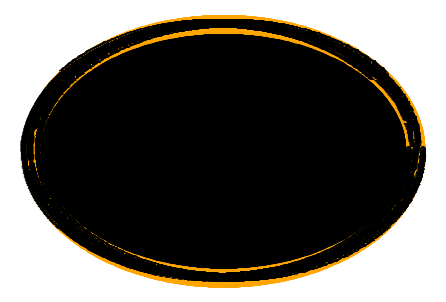

In [6]:
def nx_visualize(G):
    # Visualize the graph
    %matplotlib inline
    nx.draw_shell(G, with_labels=True, node_color='orange')

nx_visualize(G)

## 3. Initialization 

In [7]:
def random_walk(src, dest, min_step, neighbor_matrix):
    path=[src]
    #for i in range(step):
    while(True):
        next_node = random.choice(neighbor_matrix[path[-1]])
        path.append(next_node)
        
        if len(path) > min_step and path[-1] == dest:
            break
    return crossover.check_cycle(path)

In [8]:
def get_path_length(pop):
    # count path length of each individual
    path_length = []
    for ind in pop:
        path_length.append(len(ind))
    return path_length

In [9]:
def initial(G, s, d, iddfs_depth, population_size, neighbor_matrix):
    population = []
    for i in range(population_size):
        new_ind = random_walk(s, d, random_walk_mult * G.order(), neighbor_matrix)
        population.append(new_ind)
    return population

In [10]:
# Edge density of graph
# This is for calculating parameter (但現在還沒做)
edge_density = G.size()*2/G.order()*(G.order()-1)
print(edge_density)

100803.09599999999


## Experiments

--------------------------------------------------
population_size:  10
Path length for each initial individual: [30, 22, 34, 14, 68, 15, 44, 20, 14, 50]
   fitness        individual  hop
0    62194  [0, 563, 554, 1]    4
1    14845    [0, 69, 30, 1]    4
2    11821  [0, 163, 924, 1]    4
3    10018   [0, 886, 95, 1]    4
4     9031       [0, 924, 1]    3


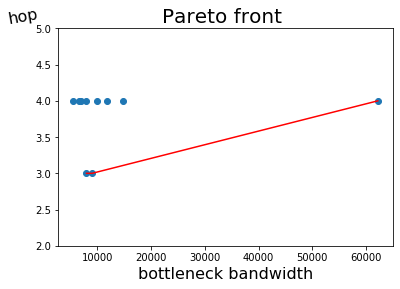

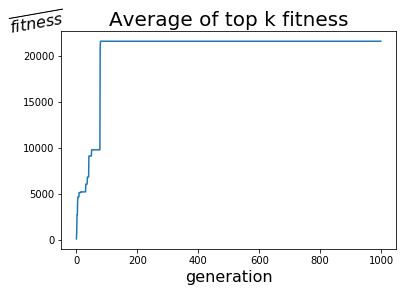

--------------------------------------------------
population_size:  20
Path length for each initial individual: [53, 59, 75, 23, 24, 42, 77, 56, 35, 34, 51, 72, 37, 46, 49, 41, 78, 10, 59, 21]
   fitness                       individual  hop
0    62194                 [0, 563, 554, 1]    4
1    38488       [0, 183, 161, 563, 554, 1]    6
2    27888       [0, 881, 500, 563, 554, 1]    6
3    27392       [0, 179, 885, 563, 554, 1]    6
4    24503  [0, 179, 885, 563, 973, 253, 1]    7


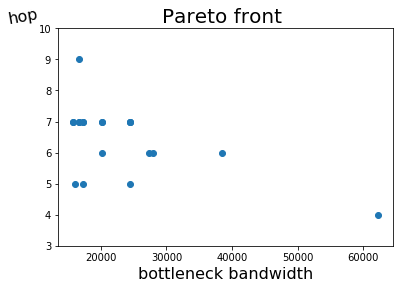

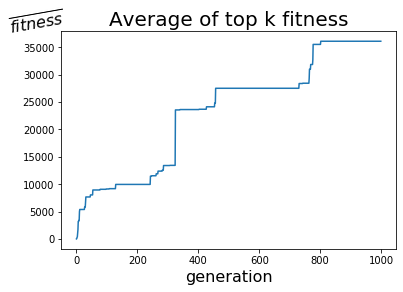

--------------------------------------------------
population_size:  50
Path length for each initial individual: [41, 36, 56, 18, 23, 33, 20, 17, 19, 67, 75, 27, 19, 6, 13, 49, 70, 42, 44, 51, 23, 42, 43, 59, 35, 66, 20, 24, 30, 47, 43, 57, 77, 32, 13, 35, 43, 19, 57, 48, 26, 72, 45, 38, 36, 73, 43, 61, 51, 31]
   fitness                  individual  hop
0   192914   [0, 563, 855, 92, 554, 1]    6
1    85086        [0, 90, 273, 253, 1]    5
2    84810       [0, 563, 911, 949, 1]    5
3    72655  [0, 881, 201, 143, 949, 1]    6
4    62194            [0, 563, 554, 1]    4


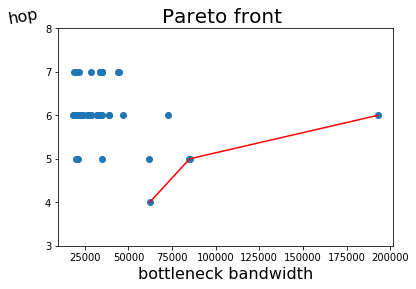

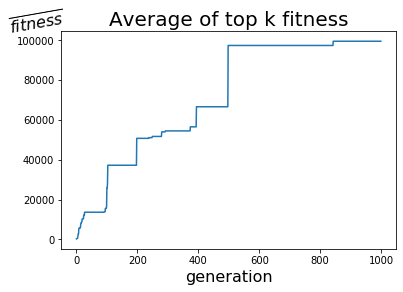

--------------------------------------------------
population_size:  100
Path length for each initial individual: [38, 81, 76, 43, 39, 42, 79, 31, 15, 66, 57, 57, 16, 59, 110, 56, 48, 79, 50, 14, 74, 44, 58, 37, 42, 33, 65, 29, 6, 48, 28, 10, 30, 41, 35, 39, 82, 29, 33, 62, 26, 40, 48, 18, 38, 69, 32, 55, 37, 32, 83, 19, 33, 53, 59, 44, 15, 13, 22, 39, 79, 37, 24, 74, 15, 16, 21, 6, 39, 32, 57, 65, 38, 54, 33, 18, 19, 83, 41, 47, 60, 32, 40, 28, 24, 62, 90, 56, 49, 32, 34, 59, 20, 25, 3, 21, 81, 51, 50, 50]
   fitness                      individual  hop
0   192914       [0, 563, 855, 92, 554, 1]    6
1    85086            [0, 90, 273, 253, 1]    5
2    72988      [0, 563, 226, 375, 467, 1]    6
3    62194                [0, 563, 554, 1]    4
4    57310  [0, 183, 149, 523, 71, 253, 1]    7


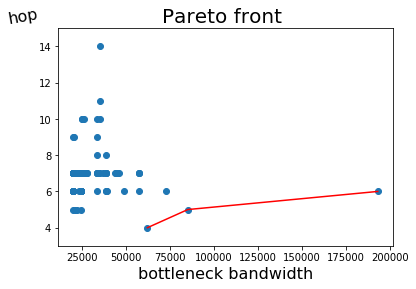

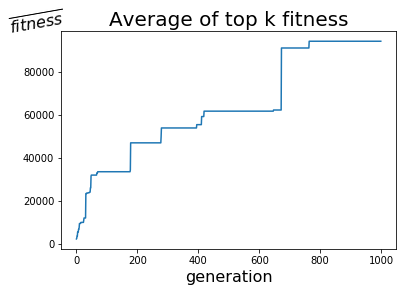

--------------------------------------------------
population_size:  150
Path length for each initial individual: [34, 52, 58, 19, 60, 49, 58, 21, 22, 56, 22, 32, 44, 14, 35, 57, 49, 15, 56, 48, 46, 79, 24, 49, 10, 44, 57, 22, 39, 37, 11, 46, 28, 29, 71, 23, 29, 50, 6, 28, 41, 47, 6, 36, 51, 69, 47, 31, 33, 32, 47, 44, 15, 41, 27, 63, 58, 42, 19, 40, 27, 73, 22, 11, 24, 33, 30, 40, 8, 43, 57, 34, 7, 55, 106, 48, 33, 15, 44, 55, 47, 62, 23, 13, 34, 77, 65, 61, 42, 18, 54, 19, 87, 45, 36, 27, 11, 24, 44, 26, 45, 6, 19, 17, 39, 49, 42, 39, 31, 45, 24, 7, 23, 52, 20, 77, 47, 31, 62, 21, 21, 36, 93, 10, 70, 24, 32, 32, 29, 12, 32, 5, 58, 38, 22, 59, 21, 47, 48, 36, 47, 49, 27, 50, 51, 41, 65, 24, 15, 65]
   fitness                  individual  hop
0   150015       [0, 179, 539, 467, 1]    5
1   105794       [0, 881, 687, 467, 1]    5
2    85086        [0, 90, 273, 253, 1]    5
3    79164  [0, 363, 726, 153, 253, 1]    6
4    62194            [0, 563, 554, 1]    4


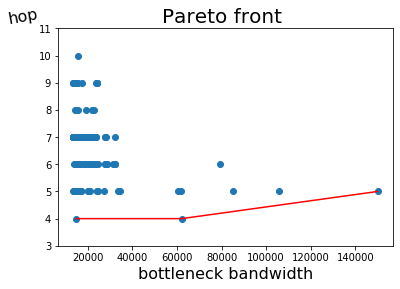

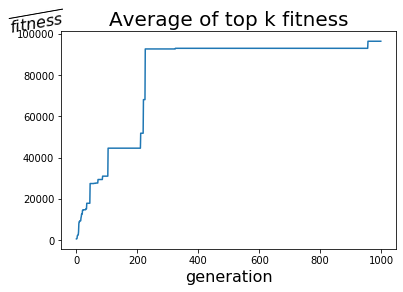

--------------------------------------------------
population_size:  200
Path length for each initial individual: [89, 39, 35, 63, 26, 57, 33, 50, 15, 52, 58, 58, 16, 63, 46, 35, 26, 35, 68, 44, 6, 87, 47, 88, 28, 31, 50, 73, 111, 33, 56, 43, 21, 31, 34, 42, 76, 18, 12, 55, 46, 24, 7, 42, 31, 19, 11, 36, 50, 40, 22, 25, 53, 16, 53, 68, 56, 14, 53, 64, 50, 52, 33, 86, 68, 50, 63, 77, 56, 60, 41, 25, 69, 26, 21, 45, 76, 34, 30, 52, 66, 46, 18, 53, 12, 67, 37, 30, 13, 5, 72, 19, 23, 12, 13, 24, 43, 15, 62, 89, 73, 20, 31, 74, 43, 92, 50, 23, 32, 30, 6, 56, 52, 15, 66, 8, 14, 91, 18, 61, 71, 41, 44, 33, 51, 55, 44, 53, 32, 25, 31, 13, 13, 35, 37, 57, 99, 45, 30, 39, 27, 42, 66, 34, 20, 43, 34, 12, 46, 45, 83, 48, 25, 38, 25, 44, 31, 18, 47, 38, 38, 49, 18, 40, 41, 38, 45, 26, 34, 43, 60, 32, 17, 26, 35, 23, 40, 24, 49, 43, 32, 60, 52, 47, 5, 15, 74, 96, 44, 6, 38, 54, 68, 22, 51, 108, 45, 13, 45, 45]
   fitness                  individual  hop
0   150015       [0, 179, 539, 467, 1]    5
1 

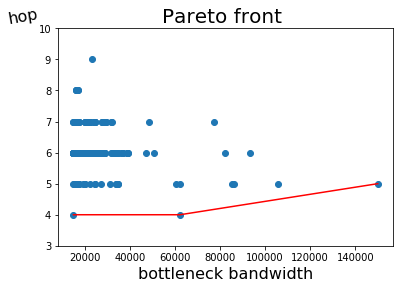

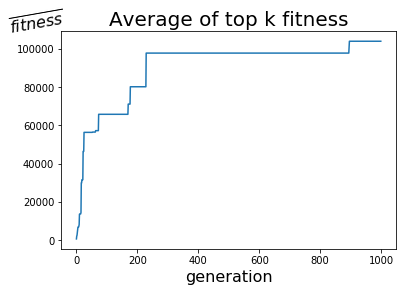

In [11]:
#candidate = np.linspace(0.1,0.2, num=2)
candidate = [10, 20, 50, 100, 150, 200]
#candidate = [50]
fitness_for_plot = []
popsize_for_plot = []

for c in candidate:
    #population_size = min(200, max(int(ratio * edge_density), k_shortest))
    population_size = min(200,  max(c, k_shortest))
    popsize_for_plot.append(population_size)
    # for example, given src=0, dst=3, max_depth=7, population_size=20
    pop = initial(G, src, dst, max_depth, population_size, neighbor_matrix)
    print('-'*50)
    print('population_size: ', population_size)
    print('Path length for each initial individual:', get_path_length(pop))
    
    # mainloop
    pop, fit_v_gen = mainloop.mainloop(generation, pop, bandwidth_matrix, neighbor_matrix, k_shortest, population_size)
    fitness_for_plot.append(fit_v_gen)
    
    # bandwidth(fitness) & path length(hops) evalutaion
    pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
    rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
    rst['hop'] = get_path_length(pop)
    rst.head(k_shortest)
    
    print("="*30)
    print(rst.head(k_shortest))
    print("="*30)
    
    # plot pareto front
    data = rst.drop(columns='individual').values
    pareto_front = plotting.plot_pareto(data, savefig=True)
    
    # plot fitness vs. generation
    plotting.plot_fitness_vs_generation(fit_v_gen, savefig=True)


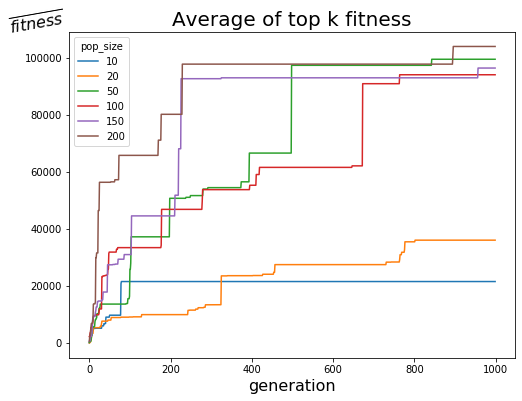

In [12]:
fig = plt.figure(figsize=(8, 6))
for idx, _ in enumerate(fitness_for_plot):
    
    plt.title("Average of top k fitness", fontsize=20)
    plt.xlabel('generation', fontsize=16)
    plt.ylabel('$\overline{fitness}$', fontsize=16, rotation=10)
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.07,1)
    plt.plot(fitness_for_plot[idx])
    plt.legend(title='pop_size',labels=popsize_for_plot,  loc='best')
    
plt.show()
# savefig
fig.savefig('./plots/experiments_'+datetime.now().strftime("%m%d_%H%M")+'.png') 

In [13]:
pd.DataFrame(fitness_for_plot)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,88.4,812.8,2721.8,2721.8,4243.0,4662.2,4662.2,4662.2,4662.2,5127.0,...,21581.8,21581.8,21581.8,21581.8,21581.8,21581.8,21581.8,21581.8,21581.8,21581.8
1,37.2,95.6,297.4,419.2,1130.8,1714.2,3231.6,3231.6,3396.8,3396.8,...,36093.0,36093.0,36093.0,36093.0,36093.0,36093.0,36093.0,36093.0,36093.0,36093.0
2,268.6,420.6,485.8,563.4,718.8,1638.2,2803.6,2803.6,5592.8,5592.8,...,99531.8,99531.8,99531.8,99531.8,99531.8,99531.8,99531.8,99531.8,99531.8,99531.8
3,2256.4,2553.2,3549.4,3549.4,5452.2,5452.2,5452.2,6702.8,6702.8,7575.8,...,94098.4,94098.4,94098.4,94098.4,94098.4,94098.4,94098.4,94098.4,94098.4,94098.4
4,607.6,634.2,861.0,2068.8,2423.8,2423.8,2590.8,4140.0,7969.4,8898.4,...,96450.6,96450.6,96450.6,96450.6,96450.6,96450.6,96450.6,96450.6,96450.6,96450.6
5,691.0,2131.6,2632.4,4127.2,5855.8,6854.8,6854.8,6854.8,7360.4,8248.8,...,104018.4,104018.4,104018.4,104018.4,104018.4,104018.4,104018.4,104018.4,104018.4,104018.4


## Plot bandwidth distribution
$F(1,1)$: F-distribution with df1 = df2 = 1

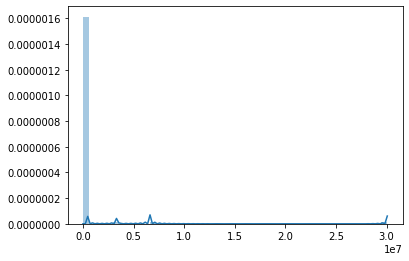

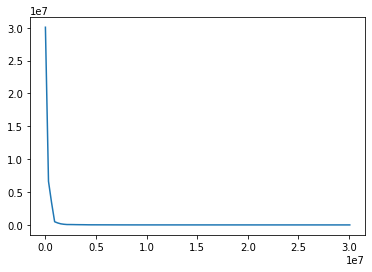

In [14]:
import seaborn as sns

fig = plt.figure(figsize=(6,4))
y = np.random.f(1, 1, 100) * 1000 + 1 
y = -np.sort(-y)
x = np.linspace(0, max(y), 100)

sns.distplot(y)
plt.show()

plt.plot(x,y)

plt.show()

## Exhausitve search (BFS)

In [15]:
"""
all_path_generator = nx.all_simple_paths(G, src, dst)
max_bandwidth_path = pd.DataFrame(pop_with_fit).tail(k_shortest).values
current_max_bandwidth = min(max_bandwidth_path[:,0])

for p in all_path_generator:
    current_bandwidth = fitness.fitness(p, bandwidth_matrix) 
    if current_bandwidth > current_max_bandwidth:
        # create new pair of bandwidth & path
        temp = max_bandwidth_path[0].copy()
        temp[0] = current_bandwidth
        temp[1] = p
        # append to table with size k_shortest 
        max_bandwidth_path = np.append(max_bandwidth_path, [temp] , axis=0)
        if len(max_bandwidth_path) > k_shortest:
            max_bandwidth_path.sort(axis=0)
            max_bandwidth_path = max_bandwidth_path[0:-1]
        current_max_bandwidth = min(max_bandwidth_path[:,0])
        
print(max_bandwidth_path)
"""

'\nall_path_generator = nx.all_simple_paths(G, src, dst)\nmax_bandwidth_path = pd.DataFrame(pop_with_fit).tail(k_shortest).values\ncurrent_max_bandwidth = min(max_bandwidth_path[:,0])\n\nfor p in all_path_generator:\n    current_bandwidth = fitness.fitness(p, bandwidth_matrix) \n    if current_bandwidth > current_max_bandwidth:\n        # create new pair of bandwidth & path\n        temp = max_bandwidth_path[0].copy()\n        temp[0] = current_bandwidth\n        temp[1] = p\n        # append to table with size k_shortest \n        max_bandwidth_path = np.append(max_bandwidth_path, [temp] , axis=0)\n        if len(max_bandwidth_path) > k_shortest:\n            max_bandwidth_path.sort(axis=0)\n            max_bandwidth_path = max_bandwidth_path[0:-1]\n        current_max_bandwidth = min(max_bandwidth_path[:,0])\n        \nprint(max_bandwidth_path)\n'

In [16]:
"""
max_bandwidth_path = pd.DataFrame(max_bandwidth_path, columns=['fitness', 'individual'])
# path length(hops) evaluation
max_bandwidth_path['hop'] = get_path_length(max_bandwidth_path['individual'].values)
max_bandwidth_path
"""

"\nmax_bandwidth_path = pd.DataFrame(max_bandwidth_path, columns=['fitness', 'individual'])\n# path length(hops) evaluation\nmax_bandwidth_path['hop'] = get_path_length(max_bandwidth_path['individual'].values)\nmax_bandwidth_path\n"